# MCMC Sampling

## Introduction

This tutorial will introduce you to some basic Monte Carlo Markov Chain (MCMC) sampling algorithms, including Metropolis-Hastings (MH) and slice sampling. These algorithms can be used to obtain a sequence of random samples from a probability distribution when direct sampling from the distribution is hard. This sequence can then serve as an approximation to the distribution (e.g. through constructing a histogram).

## Libraries

This tutorial will use the following libraries:

In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import sys

## Distributions As Mountains

We start by considering probability distritbuions as mountains, which is a good mental picture to think of when talking about distributions. In a Bayesian inference problem, data points follow a probability distribution parameterized by $n$-dimensional parameter $\theta$. We are interested in the probability distribution of $\theta$ instead of data points. We can think of $\theta$ existing in an $n$-dimensional space, and the probability distribution of $\theta$ is a mountain that sits on top of it. The height of the mountain represents the probability to that location.

Quite often, we have an initial belief of what the mountain looks like. This belief is called *prior*. After observing some data, our belief of the shape of the mountain will change. The changed belief is called *posterior*. In this case, the observed data pulls/stretches the original mountain to make it look more like the real one (hopefully).

Now let us see some examples of overhead view of mountains (heatmap) of $\theta=(\theta_1, \theta_2)$ in 2D space. We will use different colors to indicate the height of mountains. Darker red means higher mountain area and darker blue means lower mountain area.

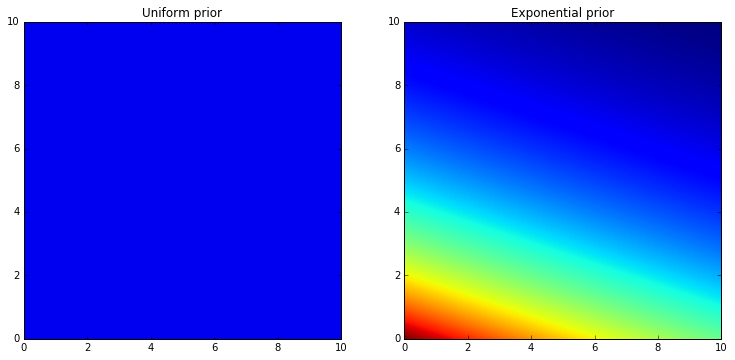

In [2]:
figsize(12.5, 12) # You can change the figure size as you like
jet = plt.cm.jet # Use jet color map
fig = plt.figure() # Create a figure
theta_1 = np.linspace(0, 10, 200)
theta_2 = np.linspace(0, 10, 200)

# Uniform prior
plt.subplot(121)
uni_theta_1 = stats.uniform.pdf(theta_1, loc=0, scale=10)
uni_theta_2 = stats.uniform.pdf(theta_2, loc=0, scale=10)
uni_M = np.dot(uni_theta_1[:, None], uni_theta_2[None, :])
im = plt.imshow(uni_M, cmap=jet, vmax=1, vmin=-.1, origin='lower', extent=(0, 10, 0, 10))
t = plt.title("Uniform prior")

# Exponential prior
fig.add_subplot(122)
exp_theta_1 = stats.expon.pdf(theta_1, scale=5)
exp_theta_2 = stats.expon.pdf(theta_2, scale=15)
exp_M = np.dot(exp_theta_1[:, None], exp_theta_2[None, :])
im = plt.imshow(exp_M, cmap=jet, origin='lower', extent=(0, 10, 0, 10))
t = plt.title("Exponential prior")

The left plot shows a 2D uniform *prior* - flat mountain - using [uniform](http://mathworld.wolfram.com/UniformDistribution.html) *prior* for both $\theta_1$ and $\theta_2$. The right plot shows a 2D exponential *prior* - curled up at lower left corner - $\theta_1$ follows [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution) with parameter 5 and $\theta_2$ follows exponential distribution with parameter 15.

Assume we have some observed 2D data whose first dimension follows a gamma distribution parametrized by $\theta_1 = 6$, whose second dimension follows a gamma distribution parameterized by $\theta_2 = 4$, i.e. the real value of $\theta$ is $(6,4)$:

In [3]:
# Assume that the true distribution ~ Normal

# Sample size of observed data X
n = 1 # Try vary this number. Default we only use one sample

# Assume that we know the following true parameters
true_theta_1 = 6
true_theta_2 = 4

# Generate a observed data set of size N according
# to the true Normal distribution with parameters 
# defined above
data = np.concatenate([stats.gamma.rvs(true_theta_1, size=(n, 1)),  # Try changing distribution
                       stats.gamma.rvs(true_theta_2, size=(n, 1))], # Try changing distribution
                      axis=1)

# Print some information
print "Generate 2D observed data set of size", n

Generate 2D observed data set of size 1


In [4]:
# Use the observed data points to compute likelihood
likelihood_theta_1 = np.array([stats.gamma.pdf(data[:, 0], theta_1_) for theta_1_ in theta_1]).prod(axis=1) # Try changing distribution
likelihood_theta_2 = np.array([stats.gamma.pdf(data[:, 1], theta_2_) for theta_2_ in theta_2]).prod(axis=1) # Try changing distribution
L = np.dot(likelihood_theta_1[:, None], likelihood_theta_2[None, :])

After pulling/stretching by observed data, the mountain changes shape.

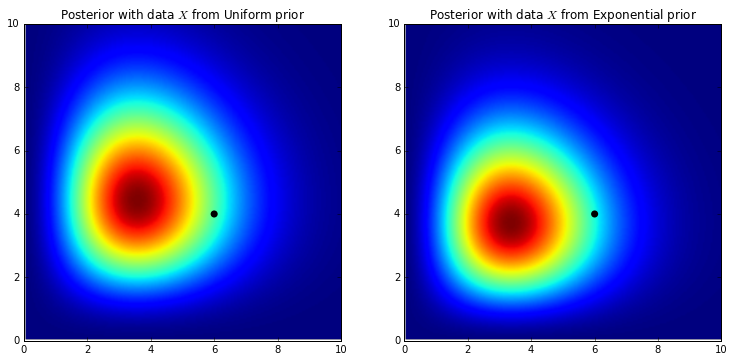

In [5]:
figsize(12.5, 12)
fig = plt.figure()

# Uniform prior -- Observed Data from gamma dist. --> posterior
fig.add_subplot(121)
plt.scatter(true_theta_1, true_theta_2, c="k", s=50, edgecolor="none")
im = plt.imshow(uni_M * L, origin='lower', cmap=jet, extent=(0, 10, 0, 10))
t = plt.title("Posterior with data $X$ from Uniform prior")

# Exponential prior -- Observed Data from gamma dist. --> posterior
fig.add_subplot(122)
plt.scatter(true_theta_1, true_theta_2, c="k", s=50, edgecolor="none")
im = plt.imshow(exp_M * L, origin='lower', cmap=jet, extent=(0, 10, 0, 10))
t = plt.title("Posterior with data $X$ from Exponential prior")

The left plot is different from the right one. Since the *prior* on the right plot has high probability towards the lower left corner, the *posterior* is also more towards the lower left corner. But both plots tend to include the true $\theta$ value $(\theta_1,\theta_2)=(6,4)$ into the high probability area of the mountain.

You can play around to see what happens to *posterior* mountains by changing the sampling size $n$ and *prior* mountains.

## Explore Mountains

We have seen distributions as mountains and their shapes change based on observed data. In the subsequent discussion, we will use distribution and mountain interchangeably. Quite often, we have no idea of the mathematical representation of a mountain, but given an $n$-dimensional point the the space, we can evaluate its altitude (probability). So how can we discribe the mountain? One possibility is to iterate over all points in the $n$-dimensional space and obtain the corresponding altitudes. However, this task gets exponentially harder in higher dimensions. Assume that each dimension can take $2$ different values, then we need to evaluate altitudes for $2^n$ points - [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). What else can we do? We can approximate a mountain by sampling points from the mountain.

In this section, we will first introduce 1D rejection sampling, and then present two MCMC sampling algorithms for high dimensional mountains.

### Rejection Sampling

We will look at how we can do sampling in 1D using rejection sampling. Suppose we want to sample $x$ from distribution $P$ which is hard to sample from. Let $Q$ be a distribution that is easy to sample from (e.g. uniform or normal) and let $k$ be a constant such that $kQ(x) \geq P(x)$ for all $x$. The following procedure then produces a sample $y$ that is exactly sampled from $P$:

1. Sample $y$ from $Q$.
2. Sample $u$ from Uniform$(0, kQ(y))$, where Uniform$(0, kQ(y))$ denotes a uniform distribution over $[0, kQ(y)]$.
3. If $u \leq P(y)$, return $y$ as a sample; otherwise, discard $y$ and goto step 1.

In summary, rejection sampling requires a covering mountain $kQ$ that sits above $P$. Rejection sampling first samples a point $y$ according to $Q$, then uniformly choose a point $u$ from $0$ to altitude of mountain $kQ$ at $y$. If $u$ does not reside above $P$, then we accept this point, otherwise we need to sample again.

The following example demonstrates the idea of rejection sampling:

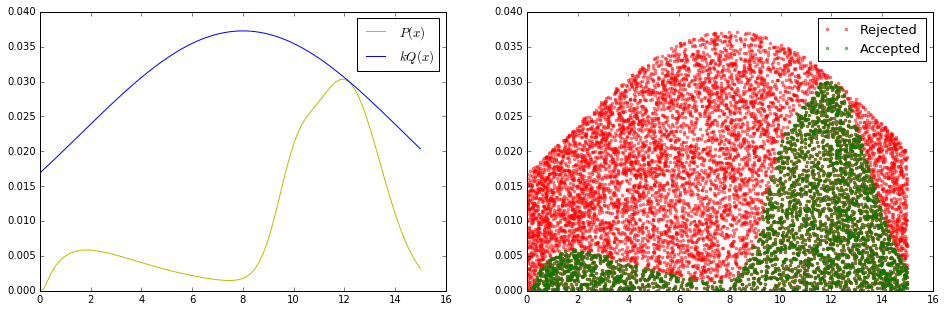

In [6]:
figsize(16, 5)
x = np.linspace(0.001,15,100)
fig = plt.figure()
ax = fig.add_subplot(121)

# P is the hard distribution we want to sample from (hidden from us)
P = lambda x: np.exp(-(x-1)**2/2./x)*(x+1)/12 + np.exp(-(x-12)**2/2**2) + 1/np.pi*np.exp(-(x-10)**2)
Px = P(x)
Psum = sum(Px)
Px = Px / Psum # Normalize
P = lambda x: (np.exp(-(x-1)**2/2./x)*(x+1)/12 + np.exp(-(x-12)**2/2**2) + 1/np.pi*np.exp(-(x-10)**2)) / Psum

# Q is the easy distribution
Q = lambda x: np.exp(-(x-8)**2/9**2)
Qx = Q(x)
Qsum = sum(Qx)
Qx = Qx / Qsum
Q = lambda x: np.exp(-(x-8)**2/9**2) / Qsum

# Constant factor
k = 3

# Plot both P and kQ
ax.plot(x, Px, label='$P(x)$', c='y')
ax.plot(x, k*Qx, label='$kQ(x)$', c='b')
ax.legend(loc=0, fontsize=13);

# Sample points
ax = fig.add_subplot(122)
y = 15*np.random.random(10000)
u = k*Q(y)*np.random.random(10000)
idx = np.where(u <= P(y))[0] # rejection criterion
ax.plot(y, u,'r.',label='Rejected', alpha=0.5)
ax.plot(y[idx], u[idx],'g.',label='Accepted', alpha=0.5)
ax.legend(loc=0, fontsize=13);

As in the left plot, $P(x)$ is completed under $kQ(x)$. The right plot shows that if a sample falls into the red region, reject the sample; if a sample falls within the green region, accept the sample.

With rejection sampling, it seems that we have just the right tool to find the shape of the hidden mountain. However, a closer look reveals some cons about this method:

1. Since $P$ is hard to sample from, we need to find an easier distribution $Q$ that is completely above $P$. The process of finding such a distribution may not be that easy.
2. Rejection sampling works well in 1D or low-dimensions, but it is damned by curse of dimensionality. As an example, if $P$ and $Q$ both are $n$-dimensional Gaussians: $P = \mathcal{N}_n(0, I)$ and $Q = \mathcal{N}_n(0, \sigma^2 I)$, then $\sigma$ has to be at least 1 in order for $Q$ to cover $P$. The probability of accepting a point is $1/\sigma^n$. With increased $n$, it won't be long until it takes forever to accept a sample.

### MCMC

Here comes the resue for sampling from high dimensional distributions. MCMC stands for Monte Carlo Markov Chain, which is a class of algorithms for sampling from a distribution. Although numerous of them, most of MCMC algorithms can be summarized as the following procedure:

0. Choose an initial position.
1. Start at current position.
2. Propose moving to a new position.
3. Accept/Reject the new position based on how likely it is from the distribution.
4.  If accept: Move to the new position and return to Step 1.
    Else: Do not move. Return to Step 1. 
5. After a specified number of iterations, return all accepted positions.

Unlike rejection sampling, which return independent samples, MCMC draws approximate, correlated samples from the distribution. In other words, MCMC performs biased random walk to explore the distribution. 

Before diving into MCMC sampling, we need some distribution to work on. I borrowed and modified the example *joint* distribution from [Isaac Slavitt's post](http://isaacslavitt.com/2013/12/30/metropolis-hastings-and-slice-sampling/). Suppose there are $N+1$ unknowns. To make the *joint* interesting, I define the distribution of one variable first:

$$v \sim \mathcal{N}(v | \mu_v, \sigma_v^2)$$

$v$ follows normal distribution with mean $\mu_v$ and variance $\sigma^2$. Then depending on $v$, define the distribution of other $N$ variables:

$$x_i \sim \mathcal{N}(x_i | \mu_{x_i}, e^v) \quad \forall i = 1, \ldots, N$$

The following code defines a class of this joint distribution. We can ask it to generate random variables or return log likelihood of a sample.

In [7]:
class my_dist():
    """ my_dist denotes the joint probability distribution of v, x1, ..., xN:
            v ~ Normal(v|mu_v, sigma_v^2),
            xi ~ Normal(xi|mu_xi, exp(v)) for i = 1, ..., N.
        
        Note: this joint distribution is adapted from 
        http://isaacslavitt.com/2013/12/30/metropolis-hastings-and-slice-sampling/
    """
    def __init__(self, mu_v=0, sigma_v=3, N=7, mu_x=np.zeros(7)):
        """ construct joint distribution class with N xi's """
        if N != len(mu_x):
            sys.exit("Dimension mismatch: N, mu_x")
        
        self.mu_v = mu_v
        self.sigma_v = sigma_v
        self.N = N
        self.mu_x = mu_x
    
    def rvs(self, n=1):
        """ rvs sample random variables from this distribution
            If n is not provided, 1 sample is returned
            Else, n samples are returned as a 2d numpy array:
                each column is a sample of length N+1
                samples are concatenated along axis=1
        """
        # create a holder for samples
        samples = np.zeros((self.N+1, n))

        for i in range(n):
            # generate rvs
            v = stats.norm(self.mu_v, self.sigma_v).rvs()
            
            x = np.zeros(self.N)
            for j in range(self.N):
                x[j] = stats.norm(self.mu_x[j], np.sqrt(np.exp(v))).rvs()
            
            # place in sample array
            samples[0, i] = v
            samples[1:, i] = x

        return samples

    def pdf(self, sample):
        """ pdf return the probability of a given sample """
        v = sample[0]
        pv = stats.norm(self.mu_v, self.sigma_v).pdf(v)
        x = sample[1:]
        px = [stats.norm(self.mu_x[i], np.sqrt(np.exp(v))).pdf(x[i]) for i in range(self.N)]
        return np.array([pv] + px)

    def loglikelihood(self, sample):
        """ loglikelihood returns log likelihood of a given sample """
        return np.sum(np.log(self.pdf(sample)))

Now let's get down to business. We will use MCMC algorithms to sample a sequence of samples $\{w^{(t)}\}_{t=1}^{T}$ from distribution $P$ as defined above. Suppose $p$ is the probability density function associated with $P$, then

$$p = \frac{\tilde{p}}{Z}$$

where $\tilde{p}$ is easy to compute and $Z$ is a deterministic normalization factor which is hard to compute. In our example, since the joint distribution is normalized, $\tilde{p} = p$.

### Metropolis-Hastings

In Metropolis-Hastings sampling, we choose a *proposal* distribution $q$ that is easy to sample from and an initial sample $w^{(0)}$. The Metropolis-Hastings algorithm is described as follows: for $t = 1, \ldots, T$,

1. Propose a new sample $w \sim q(w|w^{(t)})$;
2. Compute acceptance probability:
      $$a = \min(1, \frac{\tilde{p}(w)q(w^{(t)}|w)}{\tilde{p}(w^{(t)})q(w|w^{(t)})})$$
   Accept $w$ with probability $a$;
3. If $w$ is accepted: set $w^{(t+1)} = w$ and continue to next iteration; Else: $w^{(t+1)} = w^{(t)}$.

The following code defines a function for Metropolis-Hastings. It uses [multivariate normal](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) distribution with identity covariance matrix as proposal distribution.

In [8]:
def metropolis_hastings(p, init, iters):
    """ metropolis_hastings is implemented based on 
        http://www.cs.cmu.edu/~epxing/Class/10708-16/note/10708_scribe_lecture16.pdf
        
        p (my_dist)
        init (numpy array): intial position
        iters (int): number of iterations to run
        
        the proposal distribution is multivariate normal 
        with identity covariance matrix
    """
    # check if dist and init matches
    D = p.N + 1
    if D != len(init):
        sys.exit("Distribution and initial position dimension mismatch")
    
    # construct holder for samples
    samples = np.zeros((D, iters))

    # initialize position and log-likelihood
    cur_pos = init.copy()
    cur_llh = p.loglikelihood(cur_pos)
    
    num_accepts = 0
    for i in range(iters):
        
        # propose a new position
        new_pos = np.random.multivariate_normal(cur_pos, np.eye(D))
        new_llh = p.loglikelihood(new_pos)
        
        # conditional proposal evaluation
        new2cur = stats.multivariate_normal.logpdf(cur_pos, mean=new_pos, cov=np.eye(D))
        cur2new = stats.multivariate_normal.logpdf(new_pos, mean=cur_pos, cov=np.eye(D))
        
        rand = np.random.rand()
        if np.log(rand) < (new_llh + new2cur - cur_llh - cur2new):
            num_accepts += 1
            cur_pos = new_pos.copy()
            cur_llh = new_llh

        samples[:, i] = cur_pos.copy()
    
    print 'Acceptance ratio is', 1.0 * num_accepts / iters
    return samples

The joint distribution of our interest will have 10 dimensions as defined in __my_dist__ class. In particular, we will focus on the first dimension $v$ that follows normal distribution with mean 0 and variance $3^2$. Here we know what distribution $v$ follows, but in reality it is a hidden distribution we want to know. Thus, we are gonna pretend we don't know the shape of the mountain of $v$.

Let's start the random walk at $w_0=(0, 1, 1, 1, 1, 1, 1, 1, 1, 1)$ and run Metropolis-Hastings for 20000 iterations.

In [9]:
# Initialize distribution and initial position
w_0 = np.array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
p = my_dist(N=9, mu_x=np.zeros(9))

# Sampling (takes a few minutes)
n = 20000 # Change this number as you wish
samples = metropolis_hastings(p, w_0, n)
v = samples[0, :]

Acceptance ratio is 0.2616


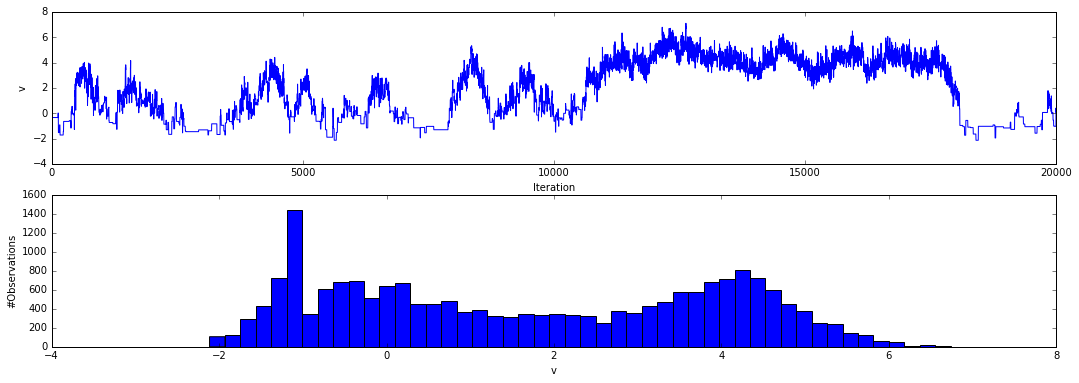

In [10]:
figsize(18, 6)

# Plot sampled v values vs iterations
fig = plt.figure()
ax = fig.add_subplot(211)
ax.plot(np.arange(n), v)
xlabel = ax.set_xlabel('Iteration')
ylabel = ax.set_ylabel('v')

# Plot histogram of values
ax = fig.add_subplot(212)
plt.hist(v, bins=50)
xlabel = ax.set_xlabel('v')
ylabel = ax.set_ylabel('#Observations')

The first plot shows how the value of $v$ changes as iteration goes. By binning these values of $v$ into histogram, the second plot shows the what the approximated mountain looks like. We can easily see that this does not look like a normal distribution at all. In fact, if we count the number of samples less than -5, we get 0:

In [11]:
print len(v[v < -5])

0


Closer examination reals the reason behind: the proposal distribution we are using assumes that all unknowns are independent, but actually the distribution of $x_i$ depeneds on the value of $v$. A large negative $v$ means that $x_i$ far away from $\mu_{x_i}$ pay a great penalty, so they are rarely seen. Therefore, assuming that all unknowns are independent does not seem right.

### Slice Sampling

We can improve the sampling quality by using a more robust sampling method - slice sampling. The algorithm takes more than a few steps to complete to sample one point, so I choose not to present the convoluted pseudocode for slice sampling here. Instead, please take a look at [this video](https://www.youtube.com/watch?v=Qr6tg9oLGTA&t=4065s) from University of Cambridge. It gives a clear walkthrough of slice sampling with some intuitive examples.

Slice sampling algorithm described in the video is in 1D. For higher dimensions, in each iteration, we can resample each unknown one-at-a-time. So if there are $n$ unknowns, we will resample $n$ times, each of which is for one unknown. The following code defines a function to perform slice sampling:

In [16]:
def slice_sampling(p, init, iters, omega):
    """ slice_sampling is implemented based on
        http://www.cs.cmu.edu/~epxing/Class/10708-16/slide/lecture16-MCMC.pdf
        
        p (my_dist)
        init (numpy array): intial position
        iters (int): number of iterations to run
        omega (numpy array): array of window size for each dimension
    """
    # check if dist and init matches
    D = p.N + 1
    if D != len(init):
        sys.exit("Distribution and initial position dimension mismatch")

    # construct holder for samples
    samples = np.zeros((D, iters))

    # initialize position and log-likelihood
    xx = init.copy()
    xx_llh = p.loglikelihood(xx)

    # for each of required number of iterations
    for i in range(iters):

        # for each dimension
        for d in range(D):
            
            # sample u
            u = xx_llh + np.log(np.random.rand())
            
            # Part 1: Stepping Out
            # sample interval (x_r[d], x_l[d] enclosing xx[d])
            r = np.random.rand()
            x_l = xx.copy()
            x_l[d] = x_l[d] - r * omega[d]
            x_r = xx.copy()
            x_r[d] = x_r[d] + (1 - r) * omega[d]

            # expand until endpoints are "outside" region under curve
            x_l_llh = p.loglikelihood(x_l)
            while x_l_llh > u:
                x_l[d] = x_l[d] - omega[d]
                x_l_llh = p.loglikelihood(x_l)
            
            x_r_llh = p.loglikelihood(x_r)
            while x_r_llh > u:
                x_r[d] = x_r[d] + omega[d]
                x_r_llh = p.loglikelihood(x_r)

            # Part 2: Sample x (Shrinking)
            x = xx.copy()
            while True:
                # Draw x from within (x_l[d], x_r[d]), then accept or shrink
                xd = x_l[d] + np.random.rand() * (x_r[d] - x_l[d])
                x[d] = xd
                xx_llh = p.loglikelihood(x)
                if xx_llh > u:
                    xx = x.copy()
                    break
                elif xd > xx[d]:
                    x_r[d] = xd
                else:
                    x_l[d] = xd

        if i % 1000 == 0: print i * 1.0 / iters, 'completed'

        samples[:, i] = xx.copy()

    return samples

We will run for a lot fewer number of iterations, because it takes some time to sample one point. Note that all sampled points are accepted.

In [17]:
# Initialize distribution and initial position
w_0 = np.array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
p = my_dist(N=9, mu_x=np.zeros(9))

# Sampling (it's gonna run for quite some time)
omega = np.ones(10);
n = 4000 # Change this number as you wish
samples = slice_sampling(p, w_0, n, omega)
v = samples[0, :]

0.0 completed


/Users/haboric/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:53: RuntimeWarning: divide by zero encountered in log


0.25 completed
0.5 completed
0.75 completed


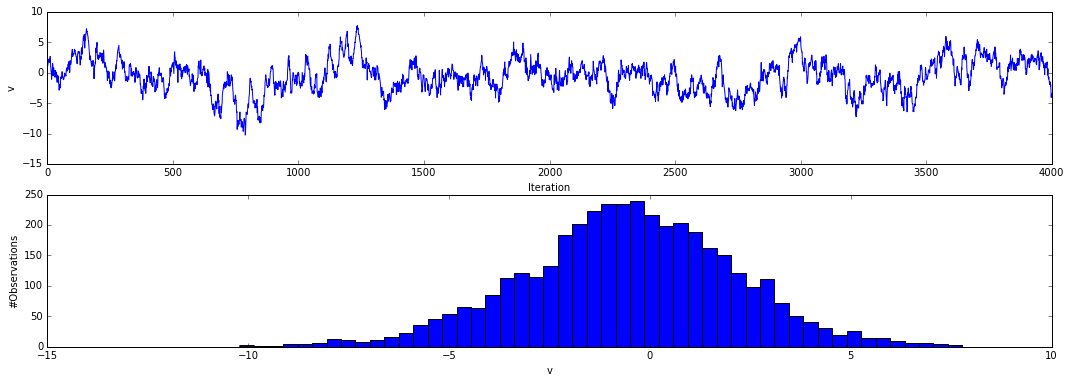

In [18]:
figsize(18, 6)

# Plot sampled v values vs iterations
fig = plt.figure()
ax = fig.add_subplot(211)
ax.plot(np.arange(n), v)
xlabel = ax.set_xlabel('Iteration')
ylabel = ax.set_ylabel('v')

# Plot histogram of values
ax = fig.add_subplot(212)
plt.hist(v, bins=50)
xlabel = ax.set_xlabel('v')
ylabel = ax.set_ylabel('#Observations')

Now the approximated distribution for $v$ looks more like a normal distribution. In particular, the number of samples less than -5 is no longer 0:

In [19]:
print len(v[v < -5])

212


### Burn-in period

For an MCMC algorithm, the sampling starts at some initial position. Depending on the specific sampling method, it may be stuck in a neighborhood of the initial position for a while until it gets out of the area and move to other areas with higher probability. Since the initial sampling occurs in a non-stable state (biased toward the neighborhood), the first few hundreds or thousands of iterations are called burn-in period, which can be discarded.

## Summary and references

This tutorial covers briefly about the context in which we want to do sampling, rejection sampling in low dimensions and MCMC algorithms (in particular, Metropolis-Hastings and slice sampling) for sampling from high dimensional distributions. If you want to dig more into MCMC sampling, you can refer to the following links:
- http://www.cs.cmu.edu/~epxing/Class/10708-16/slide/lecture16-MCMC.pdf
- http://www.cs.cmu.edu/~epxing/Class/10708-16/note/10708_scribe_lecture16.pdf
- http://python-for-signal-processing.blogspot.com/2014/02/methods-of-random-sampling-using.html
- http://isaacslavitt.com/2013/12/30/metropolis-hastings-and-slice-sampling/
- http://www.mit.edu/~ilkery/papers/MetropolisHastingsSampling.pdf